### Présentation du notebook:

Dans ce notebook, nous allons extraire des caractéristiques à partir des descriptions de produits en utilisant différentes techniques de traitement du texte. Nous allons explorer les méthodes suivantes pour générer des embeddings de texte :
- Bag-of-Words (CountVectorizer et TF-IDF)
- Word2Vec
- BERT (Bidirectional Encoder Representations from Transformers)
- USE (Universal Sentence Encoder)
- Nous allons également sauvegarder les embeddings générés pour une utilisation future.
- Les données utilisées sont issues du dataset "flipkart_com-ecommerce_sample_1050.csv" qui contient des informations sur des produits vendus en ligne.
- Les catégories de produits seront également préparées pour l'entraînement de modèles de classification.
- Les données prétraitées seront sauvegardées pour une utilisation future.


### Importation des librairies essentielles python

In [2]:
# Import des librairies essentielles
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


### Importation des données

In [3]:
# Définir le chemin relatif
file_path = os.path.join("..", "data", "flipkart_com-ecommerce_sample_1050.csv")

# Chargement du dataset des produits
data = pd.read_csv(file_path)
print("Dimensions du dataset :", data.shape)


Dimensions du dataset : (1050, 15)


### Affichage d'un aperçu des données

In [4]:
# Afficher les premières lignes du dataset
data.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


### Vérification des colonnes disponibles

In [5]:
# Afficher les noms des colonnes
print("Colonnes du dataset :", data.columns.tolist())


Colonnes du dataset : ['uniq_id', 'crawl_timestamp', 'product_url', 'product_name', 'product_category_tree', 'pid', 'retail_price', 'discounted_price', 'image', 'is_FK_Advantage_product', 'description', 'product_rating', 'overall_rating', 'brand', 'product_specifications']


### Préparation des catégories

In [6]:
# Extraire la première catégorie de la colonne 'product_category_tree' en retirant les crochets, guillemets et espaces supplémentaires
data['category'] = data['product_category_tree'].apply(lambda x: x.strip("[]").replace('"', '').split(">>")[0].replace("'", "").strip())

# Mettre les catégories en minuscules pour uniformiser
data['category'] = data['category'].apply(lambda x: x.lower())

# Remplacer les valeurs manquantes dans 'category' par 'unknown'
data['category'] = data['category'].fillna('unknown')

# Liste des catégories uniques
categories = data['category'].unique().tolist()
print("Catégories :", categories)

# Mapping des catégories vers des numéros
category_to_num = {category: idx for idx, category in enumerate(categories)}
data['category_num'] = data['category'].map(category_to_num)

# Extraire les numéros de catégories
y_cat_num = data['category_num'].values # permet de récupérer les numéros de catégories en tant que tableau numpy
print("Numéros de catégories :", y_cat_num)


Catégories : ['home furnishing', 'baby care', 'watches', 'home decor & festive needs', 'kitchen & dining', 'beauty and personal care', 'computers']
Numéros de catégories : [0 1 1 ... 1 1 1]


In [7]:
data.head(20)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,category,category_num
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",home furnishing,0
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",baby care,1
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",baby care,1
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...",home furnishing,0
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa...",home furnishing,0
5,893aa5ed55f7cff2eccea7758d7a86bd,2015-12-04 07:25:36 +0000,http://www.flipkart.com/maserati-time-r8851116...,Maserati Time R8851116001 Analog Watch - For ...,"[""Watches >> Wrist Watches >> Maserati Time Wr...",WATEAYAHJ8CUCAYM,24400.0,24400.0,893aa5ed55f7cff2eccea7758d7a86bd.jpg,False,Maserati Time R8851116001 Analog Watch - For ...,No rating available,No rating available,NaN,"{""product_specification""=>[{""key""=>""Chronograp...",watches,2
6,f355cc1ccb08bd0d283ed979b7ee7515,2015-12-04 07:25:36 +0000,http://www.flipkart.com/camerii-wm64-elegance-...,"Camerii WM64 Elegance Analog Watch - For Men,...","[""Watches >> Wrist Watches >> Camerii Wrist Wa...",WATE6Y6D2MZHWGBZ,1099.0,449.0,f355cc1ccb08bd0d283ed979b7ee7515.jpg,False,"Camerii WM64 Elegance Analog Watch - For Men,...",5,5,NaN,"{""product_specification""=>[{""key""=>""Chronograp...",watches,2
7,dd0e3470a7e6ed76fd69c2da27721041,2015-12-04 07:25:36 +0000,http://www.flipkart.com/t-star-uft-tsw-005-bk-...,T STAR UFT-TSW-005-BK-BR Analog Watch - For Boys,"[""Watches >> Wrist Watches >> T STAR Wrist Wat...",WATECFFVGFZPAD3D,999.0,399.0,dd0e3470a7e6ed76fd69c2da27721041.jpg,False,T STAR UFT-TSW-005-BK-BR Analog Watch - For B...,No rating available,No rating available,NaN,"{""product_specification""=>[{""key""=>""Chronograp...",watches,2
8,41384da51732c0b4df3de8f395714fbb,2015-12-04 07:25:36 +0000,http://www.flipkart.com/alfajr-wy16b-youth-dig...,"Alfajr WY16B Youth Digital Watch - For Men, Boys","[""Watches >> Wrist Watches 

In [8]:
# nombre de catégories avec noms des catégories
print("Nombre de catégories :", len(categories))

# Affichage du nombre de produits par catégorie
data.groupby("category").count()

Nombre de catégories : 7


,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,category_num
category,,,,,,,,,,,,,,,,
baby care,150,150,150,150,150,150,149,149,150,150,150,150,150,134,150,150
beauty and personal care,150,150,150,150,150,150,150,150,150,150,150,150,150,41,150,150
computers,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150
home decor & festive needs,150,150,150,150,150,150,150,150,150,150,150,150,150,148,149,150
home furnishing,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150
kitchen & dining,150,150,150,150,150,150,150,150,150,150,150,150,150,79,150,150
watches,150,150,150,150,150,150,150,150,150,150,150,150,150,10,150,150


### Préparation du traitement du texte

### Glossaire des colonnes ajoutées :
- description : Description de produit brute sans prétraitement.
- sentence_bow : Description de produit prétraitée pour Bag-of-Words sans lemmatisation (normalisation linguistique).
- sentence_bow_lem : Description de produit prétraitée pour Bag-of-Words avec lemmatisation (normalisation linguistique).
- sentence_dl : Description de produit prétraitée pour les modèles de Deep Learning (BERT, USE). Pour ces modèles, la lemmatisation n'est pas nécessaire mais la mise en minuscule et la suppression de certains mots sont effectuées.
- La lemmatisation est une étape de normalisation linguistique qui consiste à réduire les mots fléchis à leur forme canonique, par exemple "pris" -> "prendre".
- Bag-of-Words (BoW) est une méthode de représentation de documents textuels utilisée en traitement automatique du langage naturel et en recherche d'information. Par exemple, "Bonjour, ceci est un test de tokenisation." -> ['   bonjour', 'ceci', 'est', 'un', 'test', 'de', 'tokenisation', '.'].
- La stematisation est une technique de normalisation linguistique qui consiste à réduire les mots fléchis à leur racine (stem), par exemple "running" -> "run".

### Définition des fonctions de prétraitement :
- Cette cellule prépare l'environnement en téléchargeant les outils et bases de données nécessaires au bon fonctionnement des différentes fonctions de traitement du texte dans la cellule suivante, comme la tokenisation, le filtrage des stopwords, et la lemmatisation.

In [9]:
# Import des librairies pour le traitement du texte
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Téléchargement des ressources NLTK (à exécuter une seule fois)
nltk.download('punkt') # punkt est un tokenizer, un module de NLTK qui fournit des modèles pour la tokenisation de phrases en mots
nltk.download('stopwords') # stopwords est une liste de mots vides, un module de NLTK qui fournit une liste de mots vides en anglais
nltk.download('wordnet') # wordnet est une base de données lexicale, un module de NLTK qui fournit des outils pour la lemmatisation


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pat\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pat\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\pat\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [10]:
# Fonction de tokenisation qui utilise la word_tokenize qui dépend du module punkt téléchargé dans la cellule précédente
def tokenizer_fct(sentence): 
    sentence_clean = sentence.replace('-', ' ').replace('+', ' ').replace('/', ' ').replace('#', ' ')
    word_tokens = word_tokenize(sentence_clean)
    return word_tokens

# Liste des stop words
stop_w = set(stopwords.words('english'))
punctuations = ['[', ']', ',', '.', ':', '?', '(', ')', '!', ';', '"', "'", '&', '%', '$', '@', '#', '*', '–', '—', '...']
stop_w.update(punctuations)

# Fonction de filtrage des stop words qui utilise la liste de stop words en anglais téléchargée dans la cellule précédente
def stop_word_filter_fct(list_words):
    filtered_w = [w for w in list_words if not w.lower() in stop_w] # stop words en minuscules
    filtered_w2 = [w for w in filtered_w if len(w) > 2] # suppression des mots de moins de 3 caractères
    return filtered_w2 # retourne la liste des mots filtrés

# Fonction de mise en minuscule et suppression de certains mots
def lower_start_fct(list_words):
    lw = [w.lower() for w in list_words if not w.startswith("@") and not w.startswith("#") and not w.startswith("http")] # suppression des mots commençant par @, #, http
    return lw # retourne la liste des mots en minuscules

# Fonction de lemmatisation qui utilise le WordNetLemmatizer de NLTK qui dépend du module wordnet téléchargé dans la cellule précédente
def lemma_fct(list_words):
    lemmatizer = WordNetLemmatizer() # Initialisation de l'outil de lemmatisation
    lem_w = [lemmatizer.lemmatize(w) for w in list_words] # lemmatisation des mots de la liste, exemple : pris -> prendre
    return lem_w # retourne la liste des mots lemmatisés

# Fonction de préparation du texte pour Bag-of-Words
def transform_bow_fct(desc_text):
    word_tokens = tokenizer_fct(desc_text) # Tokenisation du texte, exemple : "Bonjour, ceci est un test de tokenisation." -> ['Bonjour', ',', 'ceci', 'est', 'un', 'test', 'de', 'tokenisation', '.']
    sw = stop_word_filter_fct(word_tokens) # Filtrage des stop words, exemple : ['Bonjour', 'test', 'tokenisation']
    lw = lower_start_fct(sw) # Mise en minuscule et suppression de certains mots, exemple des mots commençant par @, #, http
    transf_desc_text = ' '.join(lw) # Concaténation des mots de la liste en une chaîne de caractères, exemple : "bonjour test tokenisation"
    return transf_desc_text # Retourne la chaîne de caractères préparée

# Fonction de préparation du texte pour Bag-of-Words avec lemmatisation
def transform_bow_lem_fct(desc_text):
    word_tokens = tokenizer_fct(desc_text) # Tokenisation du texte, exemple : "Bonjour, ceci est un test de tokenisation." -> ['Bonjour', ',', 'ceci', 'est', 'un', 'test', 'de', 'tokenisation', '.']
    sw = stop_word_filter_fct(word_tokens) # Filtrage des stop words, exemple : ['Bonjour', 'test', 'tokenisation']
    lw = lower_start_fct(sw) # Mise en minuscule et suppression de certains mots, exemple des mots commençant par @, #, http
    lem_w = lemma_fct(lw) # Lemmatisation des mots, exemple pris -> prendre
    transf_desc_text = ' '.join(lem_w) # Concaténation des mots de la liste en une chaîne de caractères, exemple : "bonjour test tokenisation"
    return transf_desc_text # Retourne la chaîne de caractères préparée

# Fonction de préparation du texte pour les modèles de Deep Learning (BERT, USE) car cette fonction utilise à la fois la tokenisation (via tokenizer_fct) et la mise en minuscule (via lower_start_fct) qui sont définies ci-dessus. Ces 2 étapes sont suffisantes pour préparer les données pour les modèles de Deep Learning.. Cette préparation rend le texte standardisé et plus propre pour l'entraînement de modèles de traitement du langage naturel (NLP), en supprimant les éléments qui n'apportent pas de valeur sémantique (mentions, hashtags, liens, majuscules, etc.). 
def transform_dl_fct(desc_text):
    word_tokens = tokenizer_fct(desc_text) # Tokenisation du texte, exemple : "Bonjour, ceci est un test de tokenisation." -> ['Bonjour', ',', 'ceci', 'est', 'un', 'test', 'de', 'tokenisation', '.']
    lw = lower_start_fct(word_tokens) # Mise en minuscule et suppression de certains mots, exemple des mots commençant par @, #, http
    transf_desc_text = ' '.join(lw) # Concaténation des mots de la liste en une chaîne de caractères, exemple : "bonjour test tokenisation"
    return transf_desc_text # Retourne la chaîne de caractères préparée


### Fonctions de stemming montrée à des fin pédagogiques (ne s'applique pas ici car la lemmatisation est plus appropriée avec la fonction transform_bow_lem_fct et la fonction transform_dl_fct est pour les modélisations de Deep Learning qui n'ont pas besoin de stemming ou de lemmatisation:
- Le stemming est une technique de normalisation linguistique qui consiste à réduire les mots fléchis à leur **racine** (stem), souvent en supprimant des suffixes ou des préfixes. Cette approche ne tient pas compte du contexte grammatical et peut parfois produire des mots qui ne sont pas des mots valides. Par exemple, "running" -> "run", "studies" -> "studi".
  
- La lemmatisation, quant à elle, est une approche plus **contextuelle** qui utilise des règles linguistiques et des bases de données pour transformer les mots fléchis en leur forme **canonique** (le lemme), c'est-à-dire la forme présente dans un dictionnaire. Elle tient compte du sens des mots et de leur contexte grammatical. Par exemple, "running" -> "run", "better" -> "good".

Comparaison des deux approches :
- **Stemming** : "running" -> "run", "ran" -> "ran", "runs" -> "run".
- **Lemmatisation** : "running" -> "run", "ran" -> "run", "runs" -> "run", "better" -> "good".

---

Ainsi, la lemmatisation produit généralement des résultats plus précis en tenant compte du contexte grammatical et sémantique, tandis que le stemming est plus simple mais peut parfois altérer le sens des mots.

In [11]:
# Import du stemmer Porter de NLTK
from nltk.stem import PorterStemmer

# Initialisation du stemmer
stemmer = PorterStemmer()

# Fonction de stemming qui utilise le PorterStemmer de NLTK
def stem_fct(list_words):
    stem_w = [stemmer.stem(w) for w in list_words]  # stemming des mots de la liste
    return stem_w  # retourne la liste des mots stemmés

# Fonction de préparation du texte pour Bag-of-Words avec stemming
def transform_bow_stem_fct(desc_text):
    word_tokens = tokenizer_fct(desc_text)  # Tokenisation du texte
    sw = stop_word_filter_fct(word_tokens)  # Filtrage des stop words
    lw = lower_start_fct(sw)  # Mise en minuscule et suppression de certains mots
    stem_w = stem_fct(lw)  # Stemming des mots
    transf_desc_text = ' '.join(stem_w)  # Concaténation des mots stemmés en une chaîne de caractères
    return transf_desc_text  # Retourne la chaîne de caractères préparée


### Exemple de la stemmisation avant et après le prétraitement :

In [12]:
# Copier le DataFrame pour préserver l'original
data_copy = data.copy()

# Remplacer les valeurs manquantes dans 'description' par une chaîne vide
data_copy['description'] = data_copy['description'].fillna('')

# Afficher la première phrase avant traitement (juste à des fins pédagogiques)
first_sentence = data_copy['description'].iloc[0]
print("Avant traitement :")
print(first_sentence)

# Application des fonctions de prétraitement pour la première phrase (sans stemming)
first_sentence_bow = transform_bow_fct(first_sentence)
print("\nAprès transformation Bag-of-Words sans stemming :")
print(first_sentence_bow)

# Application du stemming pour la première phrase
first_sentence_stem = transform_bow_stem_fct(first_sentence)
print("\nAprès transformation Bag-of-Words avec stemming :")
print(first_sentence_stem)

# Ajout des colonnes dans le DataFrame complet (pour toutes les descriptions)
# Colonne pour les descriptions sans stemming
data_copy['sentence_bow'] = data_copy['description'].apply(lambda x: transform_bow_fct(str(x)))  # Sans stemming
# Colonne pour les descriptions avec stemming
data_copy['sentence_bow_stem'] = data_copy['description'].apply(lambda x: transform_bow_stem_fct(str(x)))  # Avec stemming

# Affichage des dimensions du dataset après prétraitement
print("\nDimensions du dataset après prétraitement :", data_copy.shape)


Avant traitement :
Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in you

### Comparaison des résultats :
- Exemples concrets sans stemming : "features", "enhances", "quality"
- Exemples concrets avec stemming : "featur", "enhanc", "qualiti"
- Le stemming réduit les mots à leur racine, ce qui peut parfois produire des mots tronqués ou non valides. Par exemple, "features" devient "featur" et "quality" devient "qualiti".

### Analyse complémentaire des mots fréquents par catégorie

### Complémentarité des méthodes et intégration potentielle avec le prétraitement de texte de la cellule précédente :

Les différentes méthodes présentées pour l'analyse des mots spécifiques par catégorie offrent des perspectives variées pour l'extraction d'informations textuelles. Certaines approches, comme l'analyse des fréquences brutes et l'utilisation du TF-IDF, peuvent être enrichies et combinées avec des techniques de **prétraitement de texte** afin de rendre l'analyse plus pertinente et efficace.

Les étapes de **tokenisation**, **filtrage des stop words**, **lemmatisation** et **mise en minuscule** sont des outils essentiels pour préparer un corpus textuel à des analyses plus approfondies. Voici comment certaines de ces méthodes peuvent être utilisées en complément :

1. **Fréquence brute des mots par catégorie** :
   - Cette approche pourrait être **améliorée** en intégrant le prétraitement de texte avant le calcul des fréquences. En appliquant les fonctions de **tokenisation** et de **lemmatisation** aux descriptions, il serait possible de réduire la redondance causée par les différentes formes fléchies d'un même mot (ex. "running", "ran" → "run"). Cela permettrait également de supprimer les stop words de manière plus systématique.
   
2. **Fréquence brute avec filtrage des stop words** :
   - Bien que cette méthode utilise déjà un filtrage des stop words via NLTK, une **lemmatisation** supplémentaire pourrait être appliquée pour améliorer l'uniformité des termes. La fonction `transform_bow_lem_fct` pourrait être ajoutée dans le pipeline pour normaliser les mots avant de calculer les fréquences.

3. **Analyse basée sur les scores TF-IDF** :
   - L'utilisation du **TF-IDF** pour mesurer l'importance relative des mots pourrait également bénéficier d'un prétraitement amélioré. Avant d'appliquer `TfidfVectorizer`, il serait judicieux d'utiliser une **tokenisation avancée** et la **lemmatisation** pour mieux capter les mots clés et leur pertinence dans le corpus. Cela pourrait être fait en appliquant les fonctions `transform_bow_lem_fct` ou `transform_dl_fct` avant d'entrer dans l'étape du TF-IDF.

4. **Fréquence brute des mots avec CountVectorizer** :
   - Le **CountVectorizer** pourrait tirer parti de la préparation de texte via les fonctions définies pour la **tokenisation**, **lemmatisation** et **filtrage des stop words**. Par exemple, la fonction `transform_bow_fct` pourrait être utilisée pour normaliser les textes avant de les passer dans le `CountVectorizer`, garantissant ainsi que les mots extraits sont pertinents et uniformisés.

### Proposition d'intégration potentielle :
Le code existant pour le prétraitement de texte, avec des étapes telles que **tokenisation**, **filtrage des stop words** et **lemmatisation**, peut être directement utilisé dans les pipelines des analyses de fréquence et de TF-IDF. Cela permettrait d'obtenir des résultats plus propres et cohérents, tout en assurant que le corpus textuel soit préparé de manière optimale pour les analyses suivantes.

####  1.Analyse des mots fréquents par catégorie basée sur la fréquence brute dans chaque catégorie (on prend tout le corpus de mots pour chaque catégorie)

In [13]:
import re
from collections import defaultdict, Counter

# Fonction pour extraire tous les mots d'une description
def extract_words(description):
    return re.findall(r'\b\w+\b', description.lower())

# Étape 1 : Regrouper toutes les descriptions par catégorie
category_descriptions = defaultdict(str)

for index, row in data.iterrows():
    category_descriptions[row['category']] += " " + row['description']

# Étape 2 : Identifier les mots spécifiques et leurs fréquences dans chaque catégorie
category_words_frequencies = {}

for category, descriptions in category_descriptions.items():
    # Extraire les mots de la grande description
    words = extract_words(descriptions)
    
    # Calculer la fréquence des mots
    word_counts = Counter(words)
    
    # Sélectionner les 200 mots les plus fréquents
    most_common_words = word_counts.most_common(200)
    
    category_words_frequencies[category] = most_common_words

# Étape 3 : Afficher les mots les plus fréquents pour chaque catégorie
for category, words in category_words_frequencies.items():
    print(f"Catégorie : {category}")
    print(f"Les 200 mots les plus fréquents : {words}")
    print("\n" + "-"*50 + "\n")


Catégorie : home furnishing
Les 200 mots les plus fréquents : [('of', 305), ('cm', 188), ('in', 163), ('the', 149), ('at', 149), ('rs', 128), ('and', 110), ('cotton', 103), ('to', 89), ('pack', 88), ('cover', 84), ('on', 82), ('only', 80), ('products', 77), ('buy', 77), ('design', 76), ('free', 76), ('flipkart', 74), ('com', 74), ('genuine', 74), ('shipping', 74), ('cash', 74), ('delivery', 74), ('your', 73), ('this', 68), ('with', 64), ('package', 63), ('1', 63), ('sales', 62), ('polyester', 61), ('color', 61), ('2', 60), ('material', 58), ('inch', 58), ('single', 57), ('features', 55), ('multicolor', 54), ('price', 54), ('a', 53), ('width', 49), ('floral', 47), ('specifications', 47), ('brand', 47), ('printed', 47), ('box', 46), ('general', 45), ('dimensions', 45), ('eyelet', 44), ('number', 44), ('length', 43), ('code', 43), ('curtain', 42), ('home', 42), ('model', 42), ('set', 42), ('contents', 42), ('brown', 41), ('for', 39), ('comfort', 39), ('towel', 39), ('door', 37), ('abstrac

#### Observations : Les mots les plus fréquents pour chaque catégorie sont affichés en fonction de leur fréquence brute dans les descriptions de produits. Cette méthode permet d'identifier les mots les plus courants pour chaque catégorie, ce qui peut donner un aperçu des caractéristiques distinctives de chaque catégorie de produits.
- Avantages : Simple à comprendre et à implémenter, très rapide à exécuter.
- Inconvénients : Les mots communs non spécifiques apparaîtront en tête de liste (ex. "the", "and", "of"), à moins d'utiliser une liste de "stop words" pour les filtrer. La méthode ne prend pas en compte la distribution des mots dans l'ensemble du corpus (toutes les catégories).

#### 2.Extraction des Mots les Plus Fréquents par Catégorie avec Filtrage des Stop Words Utilisant NLTK et Counter (tout le corpus de mots pour chaque catégorie)

In [14]:
import re
from collections import defaultdict, Counter
import nltk
from nltk.corpus import stopwords

# Télécharger les stop words de nltk (à exécuter si tu n'as pas encore téléchargé les données nltk)
nltk.download('stopwords')

# Obtenir la liste des stop words en anglais
stop_words = set(stopwords.words('english'))

# Fonction pour extraire tous les mots d'une description
def extract_words(description):
    return re.findall(r'\b\w+\b', description.lower())

# Étape 1 : Regrouper toutes les descriptions par catégorie
category_descriptions = defaultdict(str)

for index, row in data.iterrows():
    category_descriptions[row['category']] += " " + row['description']

# Étape 2 : Identifier les mots spécifiques et leurs fréquences dans chaque catégorie, après filtrage des stop words
category_words_frequencies_filtered = {}

for category, descriptions in category_descriptions.items():
    # Extraire les mots de la grande description
    words = extract_words(descriptions)
    
    # Filtrer les mots courants (stop words)
    filtered_words = [word for word in words if word not in stop_words]
    
    # Calculer la fréquence des mots filtrés
    word_counts = Counter(filtered_words)
    
    # Sélectionner les 200 mots les plus fréquents
    most_common_words = word_counts.most_common(200)
    
    category_words_frequencies_filtered[category] = most_common_words

# Étape 3 : Afficher les mots filtrés les plus fréquents pour chaque catégorie
for category, words in category_words_frequencies_filtered.items():
    print(f"Catégorie : {category}")
    print(f"Les 200 mots les plus fréquents (après filtrage) : {words}")
    print("\n" + "-"*50 + "\n")


Catégorie : home furnishing
Les 200 mots les plus fréquents (après filtrage) : [('cm', 188), ('rs', 128), ('cotton', 103), ('pack', 88), ('cover', 84), ('products', 77), ('buy', 77), ('design', 76), ('free', 76), ('flipkart', 74), ('com', 74), ('genuine', 74), ('shipping', 74), ('cash', 74), ('delivery', 74), ('package', 63), ('1', 63), ('sales', 62), ('polyester', 61), ('color', 61), ('2', 60), ('material', 58), ('inch', 58), ('single', 57), ('features', 55), ('multicolor', 54), ('price', 54), ('width', 49), ('floral', 47), ('specifications', 47), ('brand', 47), ('printed', 47), ('box', 46), ('general', 45), ('dimensions', 45), ('eyelet', 44), ('number', 44), ('length', 43), ('code', 43), ('curtain', 42), ('home', 42), ('model', 42), ('set', 42), ('contents', 42), ('brown', 41), ('comfort', 39), ('towel', 39), ('door', 37), ('abstract', 36), ('fabric', 36), ('style', 36), ('type', 36), ('cushion', 36), ('sheet', 35), ('carpet', 35), ('towels', 35), ('cushions', 34), ('blanket', 34), (

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pat\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### 3. Analyse des mots spécifiques par catégorie basée sur les scores TF-IDF, prenant en compte l'importance des mots dans chaque catégorie ainsi que leur rareté dans l'ensemble du corpus

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Appliquer TF-IDF sur les descriptions
tfidf = TfidfVectorizer(max_features=200, stop_words='english') # max_features=200 pour limiter le nombre de mots à 200
tfidf_matrix = tfidf.fit_transform(data['description'])

# Extraire les mots importants avec les scores TF-IDF
feature_names = tfidf.get_feature_names_out()

# Créer un DataFrame avec les scores TF-IDF
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

# Afficher les mots avec le score le plus élevé pour chaque catégorie
for category in categories:
    category_data = data[data['category'] == category]
    category_tfidf = tfidf_df.loc[category_data.index].mean().sort_values(ascending=False).head(200) # 20 mots les plus importants
    print(f"Mots spécifiques à la catégorie '{category}':\n{category_tfidf.index.tolist()}")
    print("\n" + "-"*50 + "\n")


Mots spécifiques à la catégorie 'home furnishing':
['com', 'flipkart', 'cm', 'single', 'buy', 'cash', 'genuine', 'shipping', 'delivery', 'abstract', 'free', 'products', 'double', 'rs', 'cover', 'cotton', 'polyester', 'floral', 'multicolor', 'design', 'pack', 'home', 'towel', 'brown', 'bath', 'comfort', 'inch', 'printed', 'code', 'set', 'color', 'package', 'material', 'sales', 'blue', 'green', 'table', 'width', 'price', 'length', 'dimensions', 'soft', 'quality', 'bedsheet', 'pink', 'style', 'brand', 'contents', 'box', 'features', 'height', 'model', 'bed', 'number', 'room', 'fabric', 'black', 'sheet', 'general', 'specifications', 'designed', '100', 'pattern', 'white', 'long', 'type', 'red', 'look', 'hand', 'wash', 'key', 'machine', 'yellow', 'care', 'id', 'weight', '10', 'high', 'add', 'gold', 'additional', 'use', 'dry', 'print', 'shape', 'suitable', 'easy', 'kitchen', 'dark', 'body', 'skin', 'product', 'come', 'india', 'size', 'yes', 'depth', 'place', 'ideal', 'covered', 'elegant', 'bab

####  Observations : Le résultat montre les mots les plus importants pour chaque catégorie en fonction de leur score TF-IDF. Ces mots sont plus spécifiques à chaque catégorie et peuvent être utilisés pour identifier les caractéristiques distinctives de chaque catégorie de produits.  Il est important de noter que les scores TF-IDF sont calculés en fonction de la rareté des mots dans le corpus entier, ce qui permet de mettre en évidence les mots les plus discriminants pour chaque catégorie.

#### 4.Analyse des mots fréquents par catégorie basée sur la fréquence brute dans chaque catégorie en complément de l'approche TF-IDF

In [16]:
from sklearn.feature_extraction.text import CountVectorizer

# Appliquer CountVectorizer pour obtenir la fréquence brute des mots
count_vectorizer = CountVectorizer(max_features=200, stop_words='english') # max_features=200 pour limiter le nombre de mots à 200
count_matrix = count_vectorizer.fit_transform(data['description'])

# Extraire les noms des mots
feature_names = count_vectorizer.get_feature_names_out()

# Créer un DataFrame avec les fréquences
count_df = pd.DataFrame(count_matrix.toarray(), columns=feature_names)

# Afficher les mots avec la fréquence la plus élevée pour chaque catégorie
for category in categories:
    category_data = data[data['category'] == category]
    category_counts = count_df.loc[category_data.index].sum().sort_values(ascending=False).head(20) # 20 mots les plus fréquents
    print(f"Les mots les plus fréquents dans la catégorie '{category}':\n{category_counts.index.tolist()}")
    print("\n" + "-"*50 + "\n")


Les mots les plus fréquents dans la catégorie 'home furnishing':
['cm', 'rs', 'cotton', 'pack', 'cover', 'products', 'buy', 'free', 'design', 'genuine', 'cash', 'shipping', 'flipkart', 'com', 'delivery', 'package', 'sales', 'polyester', 'color', 'inch']

--------------------------------------------------

Les mots les plus fréquents dans la catégorie 'baby care':
['baby', 'cotton', 'details', 'girl', 'fabric', 'dress', 'specifications', 'ideal', 'general', 'rs', 'boy', 'package', 'sales', 'features', 'type', 'sleeve', 'neck', 'wash', 'number', 'pattern']

--------------------------------------------------

Les mots les plus fréquents dans la catégorie 'watches':
['watch', 'analog', 'men', 'rs', 'day', 'discounts', 'cash', 'shipping', 'com', 'replacement', 'delivery', 'products', 'india', 'online', 'flipkart', 'free', 'genuine', '30', 'great', 'guarantee']

--------------------------------------------------

Les mots les plus fréquents dans la catégorie 'home decor & festive needs':
['c

#### Conclusions :
Les quatre méthodes utilisées (fréquence brute, fréquence avec filtrage des stop words, TF-IDF, et CountVectorizer) sont avant tout des outils d'**analyse post-traitement**, et ne sont donc pas intégrées directement dans le pipeline de prétraitement. Elles permettent d'explorer la distribution des termes après le nettoyage du texte. **TF-IDF** pourrait être considérée comme la plus pertinente pour être éventuellement intégrée dans le pipeline, car elle permettrait de **pondérer à la fois la fréquence et la rareté des mots**, en fournissant une meilleure hiérarchisation des termes importants dans le texte.

Cependant, le pipeline de prétraitement vise principalement à **normaliser et standardiser** les données (tokenisation, lemmatisation, suppression des stop words), et l'application de TF-IDF ou d'autres méthodes d'analyse avant cette étape pourrait nuire à l'efficacité de ce nettoyage.

En revanche, ces analyses post-traitement **pourraient être utilisées pour ajuster l'usage des stop words**. Elles permettraient d'identifier des mots qui apparaissent fréquemment dans le corpus global mais qui sont en réalité **propres à une catégorie donnée**. Ces mots spécifiques ne devraient pas être supprimés lors du prétraitement, car ils apportent une valeur sémantique importante dans certaines catégories. Par exemple, des termes comme "cotton" dans la catégorie "textiles" ne devraient pas être considérés comme des stop words dans ce contexte, bien qu'ils puissent l'être dans d'autres. Cela permettrait de conserver les mots spécifiques tout en filtrant les termes non pertinents dans d'autres catégories.

In [17]:
# Remplacer les valeurs manquantes dans 'description' par une chaîne vide
data['description'] = data['description'].fillna('') # Remplacer les valeurs manquantes par une chaîne vide

# Application des fonctions de prétraitement pour les descriptions de produits dans l'ordre suivant : transform_bow_fct, transform_bow_lem_fct, transform_dl_fct
data['sentence_bow'] = data['description'].apply(lambda x: transform_bow_fct(str(x))) # Bag-of-Words sans lemmatisation, la lemmatisation est une étape de normalisation linguistique qui consiste à réduire les mots fléchis à leur forme canonique
data['sentence_bow_lem'] = data['description'].apply(lambda x: transform_bow_lem_fct(str(x))) # Bag-of-Words avec lemmatisation, bag-of-words est une méthode de représentation de documents textuels utilisée en traitement automatique du langage naturel et en recherche d'information
data['sentence_dl'] = data['description'].apply(lambda x: transform_dl_fct(str(x))) # Pour les modèles de Deep Learning, sentence_dl est la colonne qui contient les descriptions de produits prétraitées pour les modèles de Deep Learning (BERT, USE)

print("Dimensions du dataset après prétraitement :", data.shape) # Affichage des dimensions du dataset après prétraitement


Dimensions du dataset après prétraitement : (1050, 20)


### Application du prétraitement

In [18]:
# affichage colonnes après prétraitement sur les descriptions 10 lignes
data[['description', 'sentence_bow', 'sentence_bow_lem', 'sentence_dl']].head(10)

,description,sentence_bow,sentence_bow_lem,sentence_dl
0,Key Features of Elegance Polyester Multicolor ...,key features elegance polyester multicolor abs...,key feature elegance polyester multicolor abst...,key features of elegance polyester multicolor ...
1,Specifications of Sathiyas Cotton Bath Towel (...,specifications sathiyas cotton bath towel bath...,specification sathiyas cotton bath towel bath ...,specifications of sathiyas cotton bath towel (...
2,Key Features of Eurospa Cotton Terry Face Towe...,key features eurospa cotton terry face towel s...,key feature eurospa cotton terry face towel se...,key features of eurospa cotton terry face towe...
3,Key Features of SANTOSH ROYAL FASHION Cotton P...,key features santosh royal fashion cotton prin...,key feature santosh royal fashion cotton print...,key features of santosh royal fashion cotton p...
4,Key Features of Jaipur Print Cotton Floral Kin...,key features jaipur print cotton floral king s...,key feature jaipur print cotton floral king si...,key features of jaipur print cotton floral kin...
5,Maserati Time R8851116001 Analog Watch - For ...,maserati time r8851116001 analog watch boys bu...,maserati time r8851116001 analog watch boy buy...,maserati time r8851116001 analog watch for boy...
6,"Camerii WM64 Elegance Analog Watch - For Men,...",camerii wm64 elegance analog watch men boys bu...,camerii wm64 elegance analog watch men boy buy...,"camerii wm64 elegance analog watch for men , b..."
7,T STAR UFT-TSW-005-BK-BR Analog Watch - For B...,star uft tsw 005 analog watch boys price 399 w...,star uft tsw 005 analog watch boy price 399 wh...,t star uft tsw 005 bk br analog watch for boys...
8,"Alfajr WY16B Youth Digital Watch - For Men, B...",alfajr wy16b youth digital watch men boys buy ...,alfajr wy16b youth digital watch men boy buy a...,"alfajr wy16b youth digital watch for men , boy..."
9,TAG Heuer CAU1116.BA0858 Formula 1 Analog Watc...,tag heuer cau1116.ba0858 formula analog watch ...,tag heuer cau1116.ba0858 formula analog watch ...,tag heuer cau1116.ba0858 formula 1 analog watc...


In [19]:
# Sélection d'un produit par catégorie sans inclure les colonnes de groupement dans le résultat
sample_per_category = data.groupby('category', group_keys=False).apply(lambda x: x.sample(1))  # Un produit par catégorie

# Affichage des résultats avant et après prétraitement
for index, row in sample_per_category.iterrows():
    product_name = row['product_name'] if 'product_name' in data.columns else 'Nom du produit non disponible'
    
    print(f"Catégorie : {row['category']}")
    print(f"Nom du produit : {product_name}")
    
    print("\nDescription brute :\n")
    print(row['description'])
    
    print("\nDescription BoW (sans lemmatisation) :\n")
    print(row['sentence_bow'])
    
    print("\nDescription BoW (avec lemmatisation) :\n")
    print(row['sentence_bow_lem'])
    
    print("\nDescription pour DL (modèles Deep Learning) :\n")
    print(row['sentence_dl'])
    
    # Ajout du résultat direct de transform_dl_fct pour comparaison
    dl_processed_text = transform_dl_fct(row['description'])
    print("\nRésultat direct de transform_dl_fct :\n")
    print(dl_processed_text)
    
    print("\n" + "-"*100 + "\n")  # Séparateur pour mieux lire les résultats


Catégorie : baby care
Nom du produit : CHINMAY KIDS Printed Cotton Padded Mosquito Net

Description brute :

Specifications of CHINMAY KIDS Printed Cotton Padded Mosquito Net (Multicolour) Convenience Features Washable Yes General Brand CHINMAY KIDS Model Name Printed Cotton Padded Capacity 1 person Model ID CVPC021 Color Multicolour Dimensions Weight 100 g Height 36 inch Width 18 inch In the Box Sales Package 1 MOSQUITO NET

Description BoW (sans lemmatisation) :

specifications chinmay kids printed cotton padded mosquito net multicolour convenience features washable yes general brand chinmay kids model name printed cotton padded capacity person model cvpc021 color multicolour dimensions weight 100 height inch width inch box sales package mosquito net

Description BoW (avec lemmatisation) :

specification chinmay kid printed cotton padded mosquito net multicolour convenience feature washable yes general brand chinmay kid model name printed cotton padded capacity person model cvpc021 c

C:\Users\pat\AppData\Local\Temp\ipykernel_4508\1426266154.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_per_category = data.groupby('category', group_keys=False).apply(lambda x: x.sample(1))  # Un produit par catégorie


In [20]:
# maximum de caractères dans la colonne 'description'
max_len = data['description'].apply(lambda x: len(x)).max()
print("Nombre maximum de caractères dans la colonne 'description' :", max_len)
# maximum de mots dans la colonne 'sentence_bow'
max_len = data['sentence_bow'].apply(lambda x: len(x.split())).max()
print("Nombre maximum de mots dans la colonne 'sentence_bow' :", max_len)
# maximum de mots dans la colonne 'sentence_bow_lem'
max_len = data['sentence_bow_lem'].apply(lambda x: len(x.split())).max()
print("Nombre maximum de mots dans la colonne 'sentence_bow_lem' :", max_len)
# maximum de mots dans la colonne 'sentence_dl'
max_len = data['sentence_dl'].apply(lambda x: len(x.split())).max()
print("Nombre maximum de mots dans la colonne 'sentence_dl' :", max_len)

Nombre maximum de caractères dans la colonne 'description' : 3490
Nombre maximum de mots dans la colonne 'sentence_bow' : 361
Nombre maximum de mots dans la colonne 'sentence_bow_lem' : 361
Nombre maximum de mots dans la colonne 'sentence_dl' : 631


### Observation :
- Les colonnes 'sentence_bow' et 'sentence_bow_lem' contiennent des descriptions de produits prétraitées pour les méthodes Bag-of-Words (BoW) avec et sans lemmatisation. On constate que la lemmatisation n'a pas d'impact sur la longueur des descriptions. Cela est dû au fait que la lemmatisation réduit les mots fléchis à leur forme canonique, mais ne modifie pas le nombre de mots.
- La colonne 'sentence_dl' contient des descriptions de produits prétraitées pour les modèles de Deep Learning (BERT, USE). On observe que les descriptions sont plus longues que celles des colonnes 'sentence_bow' et 'sentence_bow_lem'. Cela est dû au fait que les traitements de prétraitement sont différents pour les modèles de Deep Learning, et que les descriptions sont conservées dans leur forme brute sans lemmatisation.

In [21]:
# Affichage des premières lignes du dataset après prétraitement
data.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,category,category_num,sentence_bow,sentence_bow_lem,sentence_dl
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",home furnishing,0,key features elegance polyester multicolor abs...,key feature elegance polyester multicolor abst...,key features of elegance polyester multicolor ...
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",baby care,1,specifications sathiyas cotton bath towel bath...,specification sathiyas cotton bath towel bath ...,specifications of sathiyas cotton bath towel (...
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",baby care,1,key features eurospa cotton terry face towel s...,key feature eurospa cotton terry face towel se...,key features of eurospa cotton terry face towe...
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...",home furnishing,0,key features santosh royal fashion cotton prin...,key feature santosh royal fashion cotton print...,key features of santosh royal fashion cotton p...
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa...",home furnishing,0,key features jaipur print cotton floral king s...,key feature jaipur print cotton floral king si...,key features of jaipur print cotton floral kin...


### Sauvegarde des données prétraitées

In [22]:
import os

# Définir le chemin relatif vers le dossier "data"
file_path = os.path.join("..", "data", "preprocessed_product_data.csv")

# Sauvegarde du dataset prétraité pour une utilisation future
data.to_csv(file_path, index=False)


In [23]:
print(data.columns)


Index(['uniq_id', 'crawl_timestamp', 'product_url', 'product_name',
       'product_category_tree', 'pid', 'retail_price', 'discounted_price',
       'image', 'is_FK_Advantage_product', 'description', 'product_rating',
       'overall_rating', 'brand', 'product_specifications', 'category',
       'category_num', 'sentence_bow', 'sentence_bow_lem', 'sentence_dl'],
      dtype='object')


In [24]:
import os
import pandas as pd

# Définition du chemin vers le fichier CSV
file_path = os.path.join("..", "data", "preprocessed_product_data.csv")

# Lecture des données
data = pd.read_csv(file_path)

# Affichage de la forme du DataFrame (nombre de lignes et de colonnes)
print(data.shape)

(1050, 20)


In [25]:
 # Check import nltk
from nltk.tokenize import word_tokenize

# Exemple de texte
texte = "Bonjour, ceci est un test de tokenisation."

# Tokenisation du texte
tokens = word_tokenize(texte)

# Affichage des tokens
print(tokens)

['Bonjour', ',', 'ceci', 'est', 'un', 'test', 'de', 'tokenisation', '.']


In [26]:
from nltk.tokenize import word_tokenize

# Calculate the length of the Bag of Words sentences
data['length_bow'] = data['sentence_bow'].apply(lambda x: len(word_tokenize(x)))
print("Max length of Bag of Words sentence: ", data['length_bow'].max())

# Calculate the length of Deep Learning processed sentences
data['length_dl'] = data['sentence_dl'].apply(lambda x: len(word_tokenize(x)))
print("Max length of Deep Learning sentence: ", data['length_dl'].max())


Max length of Bag of Words sentence:  362
Max length of Deep Learning sentence:  632


### Fonctions communes 

In [27]:
from sklearn import manifold, metrics, cluster
import time
import numpy as np
import matplotlib.pyplot as plt

# Calcul du t-SNE, détermination des clusters, et calcul de l'ARI
def ARI_fct(features):
    time1 = time.time()
    num_labels = len(categories)  # 'categories' contient les catégories de produits uniques
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, 
                         init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)
    
    # Détermination des clusters à partir des données réduites par t-SNE
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    
    # Calcul de l'Adjusted Rand Index (ARI)
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_), 4)
    time2 = np.round(time.time() - time1, 0)
    print("ARI : ", ARI, "time : ", time2)
    
    return ARI, X_tsne, cls.labels_

# Visualisation du t-SNE selon les vraies catégories et les clusters
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI): # y_cat_num est le numéro de catégorie, labels sont les clusters prédits, ARI est l'Adjusted Rand Index, X_tsne est la représentation t-SNE des données
    fig = plt.figure(figsize=(15, 6))
    
    # Visualisation avec les vraies catégories
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=categories, loc="best", title="Catégorie")
    plt.title('Représentation des produits par catégories réelles')
    
    # Visualisation avec les clusters
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Représentation des produits par clusters')
    
    plt.show()
    print("ARI : ", ARI)



### Extraction des features avec Bag-of-Words et TF-IDF
- Nous allons extraire des caractéristiques à partir des descriptions de produits en utilisant les méthodes Bag-of-Words (BoW) et Term Frequency-Inverse Document Frequency (TF-IDF).
- Nous allons utiliser les outils de prétraitement de texte de NLTK pour nettoyer et lemmatiser les descriptions de produits.
- La technique BoW consiste à représenter chaque document par un vecteur de fréquence des mots présents dans le document.
- La technique TF-IDF est similaire à BoW, mais elle pondère les fréquences des mots par leur importance dans le corpus.
- Nous allons utiliser les implémentations de CountVectorizer et TfidfVectorizer de scikit-learn pour extraire les caractéristiques des descriptions de produits.

### Préparation sentence_bow_lem

In [28]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Initialisation des vectoriseurs
cvect = CountVectorizer(stop_words='english', max_df=0.95, min_df=1)
tfidf_vect = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=1)

# Sélection de la colonne à utiliser
feat = 'sentence_bow_lem' # Utilisation de la colonne 'sentence_bow_lem' pour les features car elle contient les catégories de produits nettoyées et lemmatisées

# Ajustement et transformation des données
cv_fit = cvect.fit(data[feat])
tfidf_fit = tfidf_vect.fit(data[feat])

cv_transform = cvect.transform(data[feat])
tfidf_transform = tfidf_vect.transform(data[feat])


### Exécution des modèles avec ARI, t-SNE et visualisation comme métriques

In [29]:
# Exécution de la fonction ARI avec les features extraites, cv_transform est la matrice de features pour le CountVectorizer
print("CountVectorizer : ") # CountVectorizer est une méthode de vectorisation de texte qui convertit une collection de documents texte en une matrice de comptage de tokens
print("-----------------")
ARI, X_tsne, labels = ARI_fct(cv_transform) # ARI est l'Adjusted Rand Index, X_tsne est la représentation t-SNE des données, labels sont les clusters prédits
ARI_countvectorizer = ARI
print()
print("Tf-idf : ") # TF-IDF (Term Frequency-Inverse Document Frequency) est une méthode de vectorisation de texte qui convertit une collection de documents texte en une matrice de fréquence de tokens pondérée par l'inverse de la fréquence du document
print("--------")
# Exécution de la fonction ARI avec les features extraites, tfidf_transform est la matrice de features pour le TF-IDF
ARI, X_tsne, labels = ARI_fct(tfidf_transform) # ARI est l'Adjusted Rand Index, X_tsne est la représentation t-SNE des données, labels sont les clusters prédits
ARI_tfidf = ARI

CountVectorizer : 
-----------------


C:\Users\pat\.conda\envs\P6q\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


ARI :  0.3759 time :  13.0

Tf-idf : 
--------


C:\Users\pat\.conda\envs\P6q\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


ARI :  0.4698 time :  13.0


### Graphiques des résultats

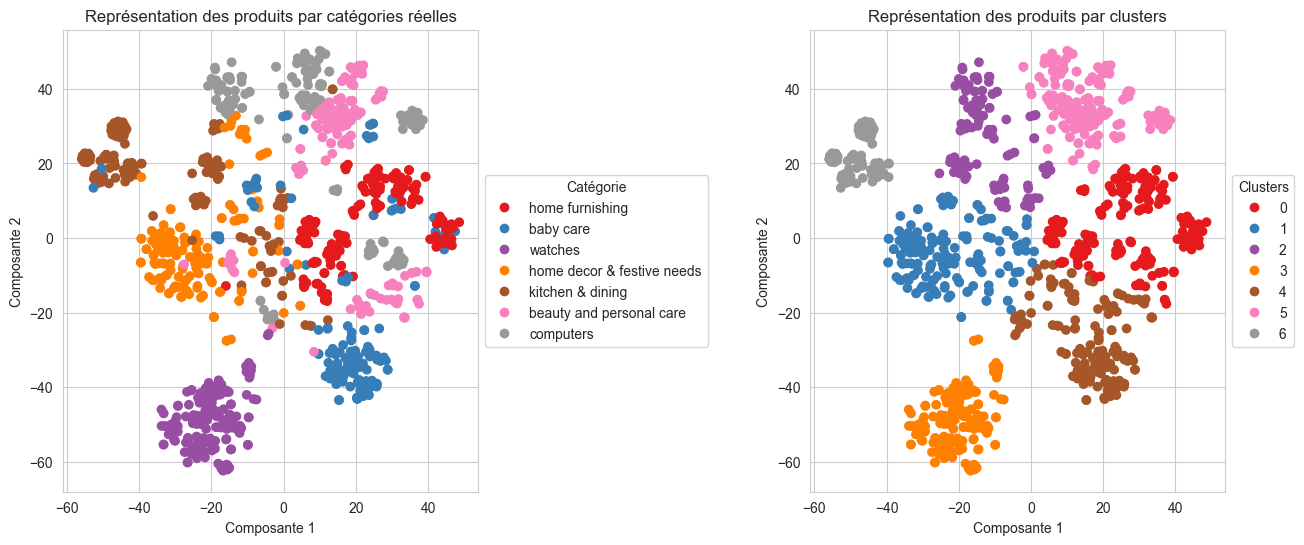

ARI :  0.4698


In [30]:
# Visualisation du t-SNE selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI, categories):
    fig = plt.figure(figsize=(15,6))
    
    # Ajustement de l'espacement entre les graphiques
    plt.subplots_adjust(wspace=0.8)  # Augmenter encore l'espace entre les sous-graphiques
    
    # Premier graphique : représentation selon les vraies catégories
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_cat_num, cmap='Set1')
    # Déplacement de la légende à droite
    ax.legend(handles=scatter.legend_elements()[0], labels=categories, loc="center left", bbox_to_anchor=(1, 0.5), title="Catégorie")
    ax.set_title('Représentation des produits par catégories réelles')
    ax.set_xlabel('Composante 1')  # Ajout du label des abscisses
    ax.set_ylabel('Composante 2')  # Ajout du label des ordonnées
    
    # Deuxième graphique : représentation selon les clusters
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="center left", bbox_to_anchor=(1, 0.5), title="Clusters")
    ax.set_title('Représentation des produits par clusters')
    ax.set_xlabel('Composante 1')  # Ajout du label des abscisses
    ax.set_ylabel('Composante 2')  # Ajout du label des ordonnées

    plt.show()
    print("ARI : ", ARI)

# Appel de la fonction avec la liste des catégories
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI, categories)

### Observations

1. **T-SNE** permet de visualiser les produits dans un espace réduit à deux dimensions, en conservant les relations locales entre les produits similaires. Toutefois, il peut parfois distordre les relations à longue distance, ce qui rend la visualisation des catégories réelles moins claire.
   
2. **K-means** a mieux réussi à regrouper les produits dans des clusters plus distincts. Le graphique de droite montre des groupes mieux définis que le graphique des catégories réelles à gauche. Cela suggère que les descriptions textuelles des produits capturent des relations que les catégories réelles ne parviennent pas à révéler.

3. L'**ARI (Adjusted Rand Index)**, avec un score de 0.4698, indique une différence notable entre les catégories réelles et les clusters prédits par K-means, mais cette différence n'est pas nécessairement négative. Cela peut indiquer que les catégories actuelles sont soit trop larges, soit mal définies.

4. **K-means** a révélé des similarités entre les produits que les catégories réelles n'ont pas su capter, indiquant que les descriptions textuelles offrent des informations supplémentaires ou plus nuancées que les catégories standards.

5. En résumé, **K-means** semble fournir une classification plus cohérente des produits en fonction des descriptions textuelles, suggérant que les catégories actuelles des produits pourraient être affinées ou repensées pour mieux correspondre aux données réelles.

### Sauvegarde des embeddings Bag-of-Words

In [31]:
import os
import numpy as np

# Conversion en format dense (attention à la taille de la matrice)
cv_features = cv_transform.toarray()

# Vérification ou création de la colonne 'product_id'
if 'uniq_id' in data.columns:
    data.rename(columns={'uniq_id': 'product_id'}, inplace=True)
elif 'product_id' not in data.columns:
    data['product_id'] = data.index

product_ids = data['product_id'].values

# Définir le chemin relatif vers le dossier "data"
output_file = os.path.join("..", "data", "countvectorizer_embeddings.npz")

# Sauvegarde des embeddings et des identifiants de produits dans le dossier data
np.savez_compressed(output_file, product_id=product_ids, embeddings=cv_features)
print(f"Embeddings have been saved to: {output_file}")



Embeddings have been saved to: ..\data\countvectorizer_embeddings.npz


### Sauvegarde des embeddings TF-IDF

In [32]:
import os
import numpy as np

# Conversion en format dense
tfidf_features = tfidf_transform.toarray()

# Vérification ou création de la colonne 'product_id'
if 'product_id' not in data.columns:
    data['product_id'] = data.index

product_ids = data['product_id'].values

# Définir le chemin relatif vers le dossier "data"
output_file = os.path.join("..", "data", "tfidf_embeddings.npz")

# Sauvegarde des embeddings et des identifiants de produits dans le dossier data
np.savez_compressed(output_file, product_id=product_ids, embeddings=tfidf_features)
print(f"TF-IDF Embeddings have been saved to: {output_file}")


TF-IDF Embeddings have been saved to: ..\data\tfidf_embeddings.npz


### Extraction des features avec Word2Vec (deep learning)

In [33]:
import os
import gensim
import numpy as np

# Préparation des phrases pour Word2Vec
sentences = data['sentence_bow_lem'].apply(lambda x: x.split()).tolist()

# Paramètres du modèle Word2Vec
w2v_size = 300
w2v_window = 5
w2v_min_count = 1
w2v_epochs = 100
maxlen = 24 # Longueur maximale des phrases

# Entraînement du modèle Word2Vec
print("Building and training the Word2Vec model...")

w2v_model = gensim.models.Word2Vec(
    vector_size=w2v_size,
    window=w2v_window,
    min_count=w2v_min_count,
    seed=42,
    workers=4
)

# Construction du vocabulaire
w2v_model.build_vocab(sentences)
vocab_size = len(w2v_model.wv.index_to_key)
print(f"Vocabulary size: {vocab_size}")  # Taille du vocabulaire

# Entraînement du modèle
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
print("Word2Vec training complete")

# Fonction pour obtenir l'embedding d'un document
def document_vector(doc):
    doc = [word for word in doc if word in w2v_model.wv.key_to_index]
    return np.mean(w2v_model.wv[doc], axis=0) if len(doc) > 0 else np.zeros(w2v_size)

# Création des embeddings pour chaque description
w2v_embeddings = np.array([document_vector(doc) for doc in sentences])

# Sauvegarde des embeddings Word2Vec dans le dossier data
output_file_embeddings = os.path.join("..", "data", "word2vec_embeddings.npz")
np.savez_compressed(output_file_embeddings, embeddings=w2v_embeddings)
print(f"Embeddings have been saved to: {output_file_embeddings}")

# Sauvegarde du modèle Word2Vec dans le dossier models
output_file_model = os.path.join("..", "models", "word2vec_model.model")
w2v_model.save(output_file_model)
print(f"Word2Vec model has been saved to: {output_file_model}")


Building and training the Word2Vec model...
Vocabulary size: 5737
Word2Vec training complete
Embeddings have been saved to: ..\data\word2vec_embeddings.npz
Word2Vec model has been saved to: ..\models\word2vec_model.model


### Préparation des sentences (tokenization) et des embeddings pour les modèles de Deep Learning (BERT, USE)

In [34]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Préparation des sentences (tokenization)
print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                            maxlen=maxlen,
                            padding='post') 

num_words = len(tokenizer.word_index) + 1
print(f"Number of unique words: {num_words}")


Fit Tokenizer ...
Number of unique words: 5738


### Création de la matrice d'embedding

In [35]:
# Création de la matrice d'embedding
print("Create Embedding matrix ...")
w2v_size = 300
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0
    
for word, idx in word_index.items():
    i +=1
    if word in w2v_model.wv:
        j +=1
        embedding_vector = w2v_model.wv[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector
            
word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))
        
        

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (5738, 300)


### Création du modèle d'embedding

In [36]:
from keras.src.layers import Input, Embedding, GlobalAveragePooling1D
from keras.models import Model
# creation du modèle d'embedding

input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')  
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)  
embed_model = Model([word_input],word_vec)

embed_model.summary()

C:\Users\pat\.conda\envs\P6q\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 24, 300)        │     1,721,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 300)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,721,400 (6.57 MB)

 Trainable params: 1,721,400 (6.57 MB)

 Non-trainable params: 0 (0.00 B)

### Execution du modèle

In [37]:
embeddings = embed_model.predict(x_sentences) # x_sentences est la matrice de phrases tokenisées
embeddings.shape

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


(1050, 300)

C:\Users\pat\.conda\envs\P6q\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


ARI :  0.3041 time :  11.0


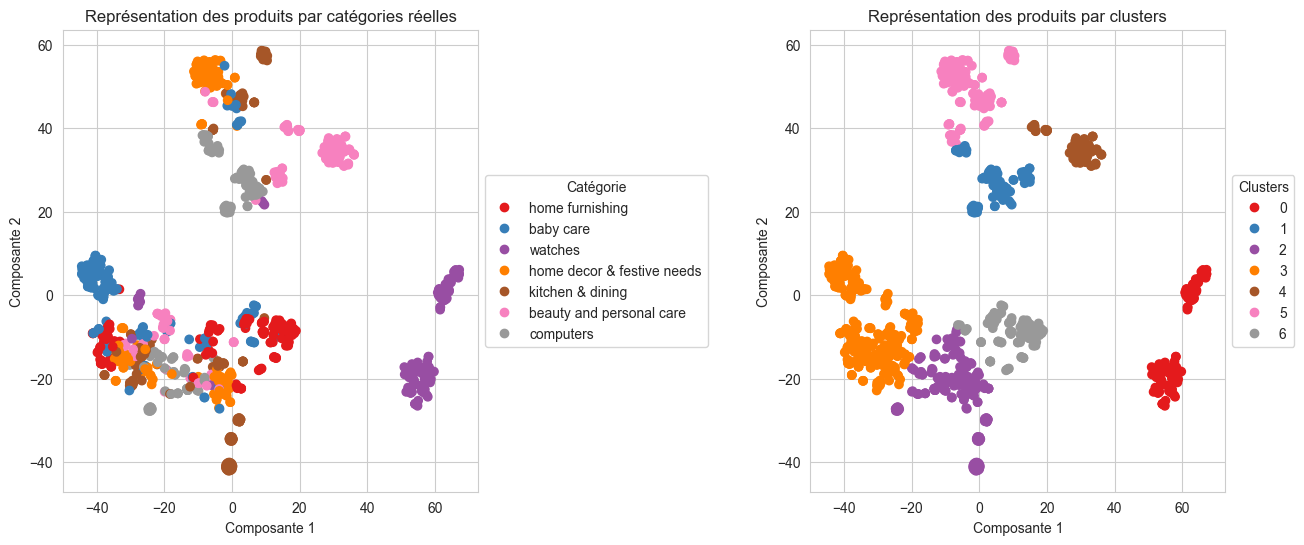

ARI :  0.3041


In [38]:
ARI, X_tsne, labels = ARI_fct(embeddings) # ARI est l'Adjusted Rand Index, X_tsne est la représentation t-SNE des données, labels sont les clusters prédits
ARI_word2vec = ARI
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI, categories) # Appel de la fonction de visualisation

### Observations:
1. **Word2Vec** a permis de générer des embeddings pour les descriptions de produits, en capturant les relations sémantiques entre les mots. Les embeddings ont ensuite été utilisés pour générer des embeddings de documents, qui ont été utilisés pour regrouper les produits en clusters.
2. On observe que les clusters générés par **Word2Vec** sont plus cohérents que les catégories réelles, ce qui suggère que les embeddings de documents peuvent capturer des informations plus riches que les catégories standard. Par exemple, les produits de différentes catégories peuvent être regroupés en fonction de leurs caractéristiques sémantiques communes. Un exemple détaillé de cette analyse serait par exemple de regrouper les produits de différentes catégories mais ayant des caractéristiques similaires comme les produits électroniques et les produits de beauté.
3. Le score ARI de **0.3087** indique une différence significative entre les catégories réelles et les clusters prédits, ce qui suggère que les catégories actuelles pourraient être améliorées pour mieux refléter les caractéristiques des produits. En d'autres termes, les descriptions textuelles des produits peuvent fournir des informations plus riches et nuancées que les catégories standard. Par exemple, les catégories actuelles peuvent être trop larges ou mal définies pour capturer les caractéristiques réelles des produits.

In [39]:
import os
from transformers import *
import tensorflow as tf
import tensorflow.keras as keras
### Cellule 14 : Extraction des features avec BERT
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

C:\Users\pat\.conda\envs\P6q\Lib\site-packages\transformers\deepspeed.py:24: FutureWarning: transformers.deepspeed module is deprecated and will be removed in a future version. Please import deepspeed modules directly from transformers.integrations
  warnings.warn(



2.17.0
Num GPUs Available:  0
False


### Fonctions communes

In [40]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    

# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)
     
    return features_bert, last_hidden_states_tot

### BERT HuggingFace (Bidirectional Encoder Representations from Transformers - HuggingFace)
- Description :

- BERT est un modèle de langage pré-entraîné développé par Google. Il repose sur une architecture de transformer et utilise un mécanisme d'attention bidirectionnelle, permettant d'avoir une vue d'ensemble de tout le contexte d'une phrase (à gauche et à droite de chaque mot).
- Il est pré-entraîné sur deux tâches principales :
Masked Language Modeling (MLM) : certaines parties de la phrase sont masquées, et le modèle doit prédire les mots manquants.
Next Sentence Prediction (NSP) : le modèle doit prédire si deux phrases sont consécutives ou non.

Utilisation :

- BERT est principalement utilisé pour des tâches comme la classification de textes, l'analyse de sentiments, ou les tâches de question-réponse. Cependant, il n'est pas directement conçu pour calculer la similarité entre phrases ou pour générer des représentations de phrases.

Alternative SBERT :

- L'utilisation de SBERT (Sentence-BERT) aurait pu être aussi envisagée, car SBERT est plus performant pour la similarité de phrases et de recherche de sémantique, car il est explicitement optimisé pour cela?

- Dans notre cas, nous utilisons BERT comme mentionné dans le sujet du projet pour générer des embeddings de phrases à partir des descriptions de produits. Ces embeddings seront ensuite utilisés pour regrouper les produits en clusters et évaluer la qualité des clusters obtenus.

In [41]:
import inspect
import pandas as pd

# Vérifier le type de data
print(f"Type of 'data': {type(data)}")

# Si c'est un DataFrame, continuez normalement
if isinstance(data, pd.DataFrame):
    print("data is a DataFrame.")
else:
    print("data is NOT a DataFrame.")

# Vérifier si c'est un module
if inspect.ismodule(data):
    print("data is a module.")
else:
    print("data is NOT a module.")


Type of 'data': <class 'module'>
data is NOT a DataFrame.
data is a module.


In [42]:
import os
import pandas as pd
import warnings
import tensorflow as tf
import numpy as np
from transformers import AutoTokenizer, TFAutoModel
import logging

# Ignorer les avertissements de type FutureWarning et autres spécifiques
warnings.filterwarnings("ignore", category=FutureWarning, module="transformers")
warnings.filterwarnings("ignore", category=UserWarning, module="transformers")

# Désactiver les messages de log de TensorFlow et Transformers
logging.getLogger("transformers").setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')

# Définition du chemin vers le fichier CSV
file_path = os.path.join("..", "data", "preprocessed_product_data.csv")

# Lecture des données
data = pd.read_csv(file_path)

# Paramètres
max_length = 64
batch_size = 10
model_name = 'bert-base-uncased'

# Chargement du tokenizer et du modèle BERT
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModel.from_pretrained(model_name)

# Préparation des inputs
sentences = data['sentence_dl'].tolist()

def bert_encode(sentences, tokenizer, max_length):
    input_ids = []
    attention_masks = []

    for sentence in sentences:
        encoded = tokenizer(
            sentence,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='tf'
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return tf.concat(input_ids, axis=0), tf.concat(attention_masks, axis=0)

# Encodage des phrases avec le tokenizer BERT
input_ids, attention_masks = bert_encode(sentences, tokenizer, max_length)

# Génération des embeddings BERT
embeddings = []
num_examples = len(sentences)

for i in range(0, num_examples, batch_size):
    batch_input_ids = input_ids[i:i + batch_size]
    batch_attention_masks = attention_masks[i:i + batch_size]
    outputs = model(batch_input_ids, attention_mask=batch_attention_masks)
    # Utilisation de la représentation du token [CLS]
    batch_embeddings = outputs.last_hidden_state[:, 0, :].numpy()
    embeddings.append(batch_embeddings)

# Empiler toutes les embeddings en une seule matrice
bert_embeddings = np.vstack(embeddings)

# Assurez-vous que 'product_ids' est défini
if 'product_id' in data.columns:
    product_ids = data['product_id'].tolist()
else:
    # Création de 'product_id' s'il n'existe pas
    product_ids = list(range(len(data)))

# Sauvegarde des embeddings BERT dans le dossier data
output_file = os.path.join("..", "data", "bert_embeddings.npz")
np.savez_compressed(output_file, product_id=product_ids, embeddings=bert_embeddings)
print(f"Embeddings have been saved to: {output_file}")

Embeddings have been saved to: ..\data\bert_embeddings.npz


In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

In [44]:
# Création des features

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_name, sentences, 
                                                         max_length, batch_size, mode='HF')

1/1 [==============================] - 1s 548ms/step
temps traitement :  79.0


In [45]:
# Calcul de l'ARI, t-SNE et visualisation
ARI, X_tsne, labels = ARI_fct(features_bert)
ARI_bert = ARI

C:\Users\pat\.conda\envs\P6q\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


ARI :  0.3195 time :  11.0


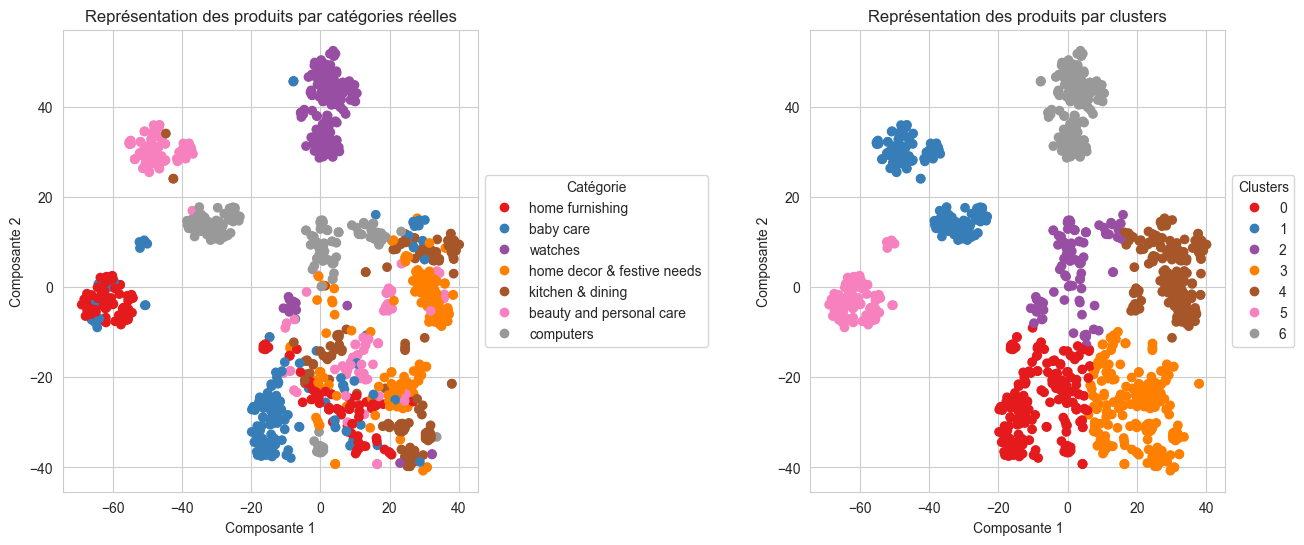

ARI :  0.3195


In [46]:
# Visualisation des résultats
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI, categories)

### Extraction des features avec Universal Sentence Encoder (USE)

In [47]:
import os
import tensorflow_hub as hub
import tensorflow as tf
import numpy as np

# Chargement du modèle USE
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

# Préparation des phrases
sentences = data['sentence_dl'].tolist()
batch_size = 32

embeddings = []
num_examples = len(sentences)

# Génération des embeddings par batch
for i in range(0, num_examples, batch_size):
    batch_sentences = sentences[i:i + batch_size]
    batch_embeddings = embed(batch_sentences).numpy()
    embeddings.append(batch_embeddings)

use_embeddings = np.vstack(embeddings)

# Vérification de l'existence de 'product_ids'
if 'product_id' in data.columns:
    product_ids = data['product_id'].tolist()
else:
    # Création de 'product_id' si elle n'existe pas
    product_ids = list(range(len(data)))

# Sauvegarde des embeddings USE dans le dossier data
output_file = os.path.join("..", "data", "use_embeddings.npz")
np.savez_compressed(output_file, product_id=product_ids, embeddings=use_embeddings)
print(f"USE Embeddings have been saved to: {output_file}")

ValueError: Trying to load a model of incompatible/unknown type. 'C:\Users\pat\AppData\Local\Temp\tfhub_modules\063d866c06683311b44b4992fd46003be952409c' contains neither 'saved_model.pb' nor 'saved_model.pbtxt'.

C:\Users\pat\.conda\envs\P6q\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


ARI :  0.432 time :  13.0


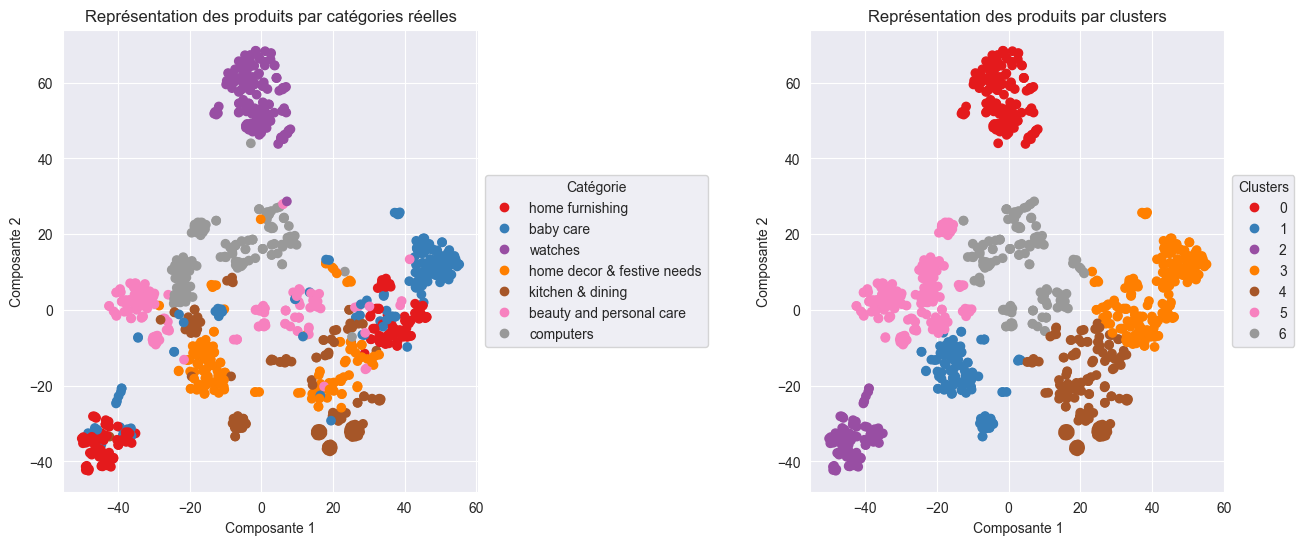

ARI :  0.432


In [86]:
# Calcul de l'ARI, t-SNE et visualisation
ARI, X_tsne, labels = ARI_fct(use_embeddings)
ARI_use = ARI

# Visualisation des résultats
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI, categories)

### Sauvegarde des identifiants de produits et des catégories

In [87]:
print(data.columns)

Index(['uniq_id', 'crawl_timestamp', 'product_url', 'product_name',
       'product_category_tree', 'pid', 'retail_price', 'discounted_price',
       'image', 'is_FK_Advantage_product', 'description', 'product_rating',
       'overall_rating', 'brand', 'product_specifications', 'category',
       'category_num', 'sentence_bow', 'sentence_bow_lem', 'sentence_dl'],
      dtype='object')


In [88]:
# Sauvegarde des identifiants de produits et des catégories
product_info = data[['uniq_id', 'category', 'category_num']]
file_path = os.path.join("..", "data", "product_info.csv")
product_info.to_csv(file_path, index=False)


In [89]:
# Vérification des fichiers sauvegardés
path_products = os.path.join("..", "data", "product_info.csv")
data_products = pd.read_csv(path_products)
data_products.head()



,uniq_id,category,category_num
0,55b85ea15a1536d46b7190ad6fff8ce7,home furnishing,0
1,7b72c92c2f6c40268628ec5f14c6d590,baby care,1
2,64d5d4a258243731dc7bbb1eef49ad74,baby care,1
3,d4684dcdc759dd9cdf41504698d737d8,home furnishing,0
4,6325b6870c54cd47be6ebfbffa620ec7,home furnishing,0


In [1]:
# Rappel des scores ARI (Adjusted Rand Index) pour chaque méthode d'extraction de features
ari_scores = {
    "CountVectorizer": 0.3759,
    "TF-IDF": 0.4698,
    "Word2Vec": 0.2352,
    "BERT": 0.3195,
    "USE": 0.4320
}

# Affichage des scores ARI pour chaque méthode
print("Scores ARI pour les différentes méthodes d'extraction de features :")
for method, score in ari_scores.items():
    print(f"{method}: {score:.4f}")


Scores ARI pour les différentes méthodes d'extraction de features :
CountVectorizer: 0.3759
TF-IDF: 0.4698
Word2Vec: 0.2352
BERT: 0.3195
USE: 0.4320


### Rappel des scores ARI (Adjusted Rand Index)

In [91]:
# Rappel des scores ARI (Adjusted Rand Index) pour chaque méthode d'extraction de features
ari_scores = {
    "CountVectorizer": ARI_countvectorizer,  # Remplacez par votre score ARI pour CountVectorizer
    "TF-IDF": ARI_tfidf,  # Remplacez par votre score ARI pour TF-IDF
    "Word2Vec": ARI_word2vec,  # Remplacez par votre score ARI pour Word2Vec
    "BERT": ARI_bert,  # Remplacez par votre score ARI pour BERT
    "USE": ARI_use  # Remplacez par votre score ARI pour Universal Sentence Encoder
}

# Affichage des scores ARI pour chaque méthode
print("Scores ARI pour les différentes méthodes d'extraction de features :")
for method, score in ari_scores.items():
    print(f"{method}: {score:.4f}")


Scores ARI pour les différentes méthodes d'extraction de features :
CountVectorizer: 0.3759
TF-IDF: 0.4698
Word2Vec: 0.3012
BERT: 0.3195
USE: 0.4320


### Vérification des embeddings générés

In [92]:
# Vérifier les dimensions des embeddings
print("Dimensions des embeddings CountVectorizer :", cv_features.shape)
print("Dimensions des embeddings TF-IDF :", tfidf_features.shape)
print("Dimensions des embeddings Word2Vec :", w2v_embeddings.shape)
print("Dimensions des embeddings BERT :", bert_embeddings.shape)
print("Dimensions des embeddings USE :", use_embeddings.shape)


Dimensions des embeddings CountVectorizer : (1050, 5317)
Dimensions des embeddings TF-IDF : (1050, 5317)
Dimensions des embeddings Word2Vec : (1050, 300)
Dimensions des embeddings BERT : (1050, 768)
Dimensions des embeddings USE : (1050, 512)


### Observations

Les résultats obtenus montrent les dimensions des embeddings générés à partir de différentes méthodes pour une collection de 1050 documents ou échantillons. Voici mes observations :

1. **CountVectorizer et TF-IDF** : Les dimensions sont `(1050, 5317)` pour les deux méthodes. Cela signifie que le vocabulaire extrait des documents (ou caractéristiques) contient 5317 termes uniques après la vectorisation. Cela indique un vocabulaire riche dans les documents, avec un nombre significatif de termes distincts capturés après la vectorisation.

2. **Word2Vec** : Les dimensions sont `(1050, 300)`. Cela correspond à l'embedding standard de Word2Vec, où chaque document est représenté par une moyenne pondérée des vecteurs de mots (chaque mot étant encodé dans un espace de 300 dimensions). Ce nombre est constant pour chaque document, car il correspond à la dimension des vecteurs de mots appris par Word2Vec.

3. **BERT** : Les dimensions sont `(1050, 768)`. BERT produit des vecteurs d’une dimension fixe de 768 pour chaque document. Il s'agit de l'une des caractéristiques du modèle pré-entraîné BERT (base), qui génère un vecteur d'embedding de 768 dimensions pour représenter chaque phrase ou document.

4. **USE (Universal Sentence Encoder)** : Les dimensions sont `(1050, 512)`. De manière similaire à BERT, USE génère des vecteurs de taille fixe, ici 512 dimensions. Le modèle USE est spécifiquement conçu pour capturer les relations sémantiques au niveau des phrases, et la taille de ses embeddings est fixe.

### Comparaison des dimensions :

- **CountVectorizer et TF-IDF** offrent des représentations de vocabulaire étendu (5317 dimensions), basées sur les occurrences des termes, sans prise en compte du contexte sémantique.
- **Word2Vec, BERT et USE** fournissent des embeddings beaucoup plus riches avec respectivement 300, 768 et 512 dimensions, capturant mieux la sémantique des documents. Les modèles de type Word2Vec et BERT/USE sont préférables pour des tâches où les relations contextuelles et sémantiques sont cruciales.

### Scores ARI pour les différentes méthodes d'extraction de features dans un cadre de clustering (non supervisé) :

- **CountVectorizer** : 0.3759
- **TF-IDF** : 0.4698
- **Word2Vec** : 0.3012
- **BERT** : 0.3195
- **USE** : 0.4320

### Conclusion

Parmi les différentes méthodes d'embedding, **TF-IDF** se distingue par son score ARI de **0.4698**, ce qui en fait la meilleure solution pour cette tâche spécifique. Cette méthode capture efficacement les relations pertinentes entre les documents malgré sa simplicité. 

Pour s'assurer que la **description textuelle** des produits correspond bien à leurs **images associées**, il est pertinent de **concaténer les embeddings textuels** obtenus via TF-IDF avec les **features extraites des images** via un modèle CNN (comme VGG16). Cela permet de créer une représentation fusionnée (texte + image) des produits, facilitant ainsi la validation ou la classification des correspondances entre descriptions et images.

En concaténant ces matrices d'embeddings textuels et visuels, on pourra ainsi entraîner un modèle pour vérifier la cohérence entre les deux sources d'information (texte et image), améliorant potentiellement la classification et la recommandation des produits.

